# Classification - Network Patrol 🕸️🚓

# Ida!!!

Na początek zrób run all wszystkiego, dalej poniżej poniżej specjalnie zrobiłem error żeby nie runowało tych wszystkich modeli (co by zajęło z 3h). `resampled_data` zawiera wszystko co wkładasz bezpośrednio do fukcji robiących cross-validation itd (patrz na modele niżej). To jest zbiór danych treningowych, który zawiera przetworzone i zbilansowane dane (czyli przykładów uczących w każdej klasie jest mniej więcej tyle samo). Zapisałem go w formacie naszego ulubionego ogórka kiszonego, żeby nie trzeba było tego puszczać za każdym razem.


Możesz spróbować użyć innych modeli, popatrzeć na wyniki użytych przez Ciebie, wszystkich poprzednich. Najbardziej chyba nam zależy, żeby użyć modelu każdego rodzaju i spróbować na nim cross-validation, kod jest poniżej, możesz zobaczyć inne modele i myślę, że sobie poradzisz (polecam SVC, LogisticRegression, KNN, coś z sklearn.naive_bayes, ...). Nie patrz za bardzo na overall_accuracy, to niewiele mówi w przypadku kiedy w test secie mamy niezbilansowane dane (sama widzisz że na confusion matrix jest najwięcej clear), dlatego chyba najlepiej patrzeć na te najmniej liczne klasy żeby porównywać modele. Wybierz najlepszy model, żeby zrobić na nim później jakiś random grid search żeby go zboostować (w trakcie tego najlepiej dać max 5-fold cross-validation bo inaczej za 100 lat się nie zrobi). A jeszcze przed tym wszystkim można zastanowić się, która z tych metryk które są liczone przy każdym modelu będzie najbardziej przydatna w naszym przypadku (może f1?). Tutaj jest takie zdanie dla inspiracji:

*Remember: in cybersecurity, correctly identifying dangerous elements is far more critical than mistakenly cutting off regular users. At the same time, try not to accidentally shut down the Internet for the entire country.*

Jak chcesz, to możesz sklonować cały ten projekt, a wysłać mi tylko ten notebook, bo pewnie tylko on się zmieni.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OrdinalEncoder

from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from utils.modeling import evaluate_models, plot_confusion_matrix
from utils.preprocessing import create_pipeline

In [71]:
# 🥒 RUN THIS!!! Load preprocessed resampled_data from the file:
with open("resampled_data.pkl", "rb") as file:
    resampled_data = pickle.load(file)

## About Imbalanced Classification

[Imbalanced Data Handling](https://github.com/Rhishikesh1997/data-imbalance)

[SMOTE and ADASYN for Imbalanced Classification](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

[Cost-Sensitive Learning for Imabalnced Classification](https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/)

[Imbalanced Multiclass Classification - Glass Indentifiaction](https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/)

[Imbalanced (Binary) Classification - Fraudulent Credit Card Transactions](https://machinelearningmastery.com/imbalanced-classification-with-the-fraudulent-credit-card-transactions-dataset/)

[Imbalanced Multiclass Classification - e-coli Bacteria](https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-e-coli-dataset/)

The Keras Python Deep Learning library also provides access to this use of cost-sensitive augmentation for neural networks via the class_weight argument on the fit() function when training models.

In [15]:
data = pd.read_csv("data/Data_set_task_3.csv")

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176640 entries, 0 to 176639
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0.1                176640 non-null  int64  
 1   Unnamed: 0                  176640 non-null  int64  
 2   DST_IP                      176640 non-null  object 
 3   SRC_IP                      176640 non-null  object 
 4   PACKETS                     176640 non-null  int64  
 5   PACKETS_REV                 176640 non-null  int64  
 6   BYTES                       176640 non-null  int64  
 7   BYTES_REV                   176640 non-null  int64  
 8   TIME_FIRST                  176640 non-null  float64
 9   TIME_LAST                   176640 non-null  float64
 10  DST_PORT                    176640 non-null  int64  
 11  SRC_PORT                    176640 non-null  int64  
 12  MEAN                        176640 non-null  int64  
 13  MEDIAN        

There seem to be many columns that should be removed manually (which have more than *50%* of missing data).

In [17]:
data

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,11618,11618,64.142.97.114.,147.32.84.165,2,0,0,0,1.313558e+09,1.313558e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176636,11619,11619,147.32.84.165.,95.130.170.231,1,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176637,11620,11620,95.130.170.231.,147.32.84.165,2,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176638,11621,11621,147.32.84.165.,199.59.164.114,2,0,0,0,1.313565e+09,1.313565e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear


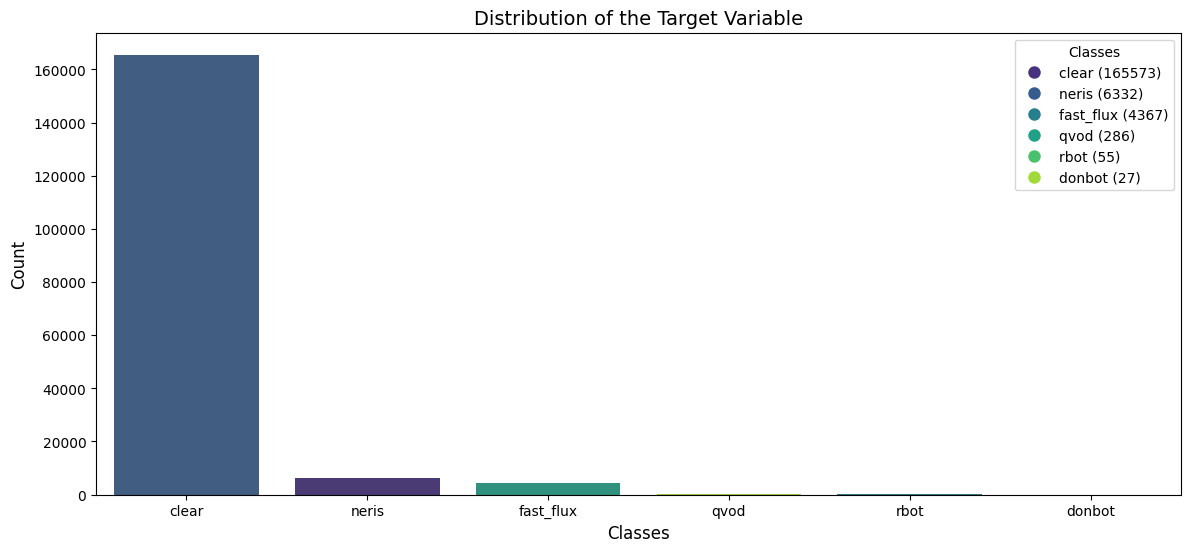

In [73]:
# 📈 Distribution of the target variable
counts = data['LABEL'].value_counts()

plt.figure(figsize=(14, 6))
ax = sns.countplot(x=data['LABEL'], palette='viridis', 
                         order=counts.index, hue=data['LABEL'])

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=sns.color_palette('viridis')[i], markersize=10) for i in range(len(counts))]
labels = [f'{label} ({counts[label]})' for label in counts.index]
ax.legend(handles, labels, title="Classes", loc='upper right', fontsize=10)

plt.title('Distribution of the Target Variable', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


## Preprocessing

1. **Drop Columns**:
   - Removes unnecessary columns that have more than *50%* of missing values. They are specified in the `drop_columns` list.
   
2. **Binary Transformation**:
   - Converts selected columns (e.g., `TRANSIENTS`, `PERIODICITY`) with `True/False` values into binary (*1* for *"True"*, *0* for *"False"*).

3. **Encoding Categorical Variables**:
   - Applies `OrdinalEncoder` to transform categorical columns (`DST_IP` and `SRC_IP`) into numeric values.

4. **Missing Value Imputation**:
   - Fills missing values in the remaining columns using the mean strategy with `SimpleImputer`.

5. **Scaling Features**:
   - Scales the data to a *0-1* range using `MinMaxScaler` to normalize feature values.

6. **Dimensionality Reduction**:
   - Reduces the feature set using PCA while retaining *99%* of the variance.

In [24]:
# Preprocessing
drop_columns = [
    "MIN_POWER", "MAX_POWER", "MIN_POWER_FREQ", "MAX_POWER_FREQ", "POWER_MEAN", "POWER_STD",
    "SPECTRAL_ENTROPY", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS", "SPECTRAL_CENTROID", "SPECTRAL_SPREAD", "SPECTRAL_SLOPE", "Unnamed: 0.1",
    "SPECTRAL_CREST", "SPECTRAL_FLUX", "PERIODICITY_SCDF", "SPECTRAL_ENERGY", "Unnamed: 0"
]

binary_columns = ["TRANSIENTS", "PERIODICITY"]

pipeline = create_pipeline(drop_columns=drop_columns, binary_columns=binary_columns)

X = data.drop(columns=["LABEL"])
y = data["LABEL"]

X_processed = pipeline.fit_transform(X)

oe = OrdinalEncoder()
y_processed = oe.fit_transform(y.values.reshape(-1, 1)) # type: ignore


In [67]:
oe.categories_

[array(['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot'],
       dtype=object)]

In [29]:
class_labels = ['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot']

**PCA** with *99%* explained variance leaves only *21* columns.

We resample the preprocessed data with **SMOTEENN**:
- over-sampling using SMOTE and cleaning using ENN.
- combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.

As a result, we obtain almost *800 000* records with almost perfectly balanced distribution of target variable.

In [75]:
# 🥷 Create resampled_data ready for cross-validation (training)
# from sklearn.model_selection import StratifiedKFold

# # SMOTEENN setup
# resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# # Cross-validation setup
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Dictionary to store resampled data for each fold
# resampled_data = {}

# for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     # Split data
#     X_train, X_val = X_processed[train_idx], X_processed[val_idx]
#     y_train, y_val = y_processed[train_idx], y_processed[val_idx]
    
#     # Resample and store
#     X_res, y_res = resample.fit_resample(X_train, y_train)
#     resampled_data[i] = (X_res, y_res, X_val, y_val)  # Store resampled and validation sets


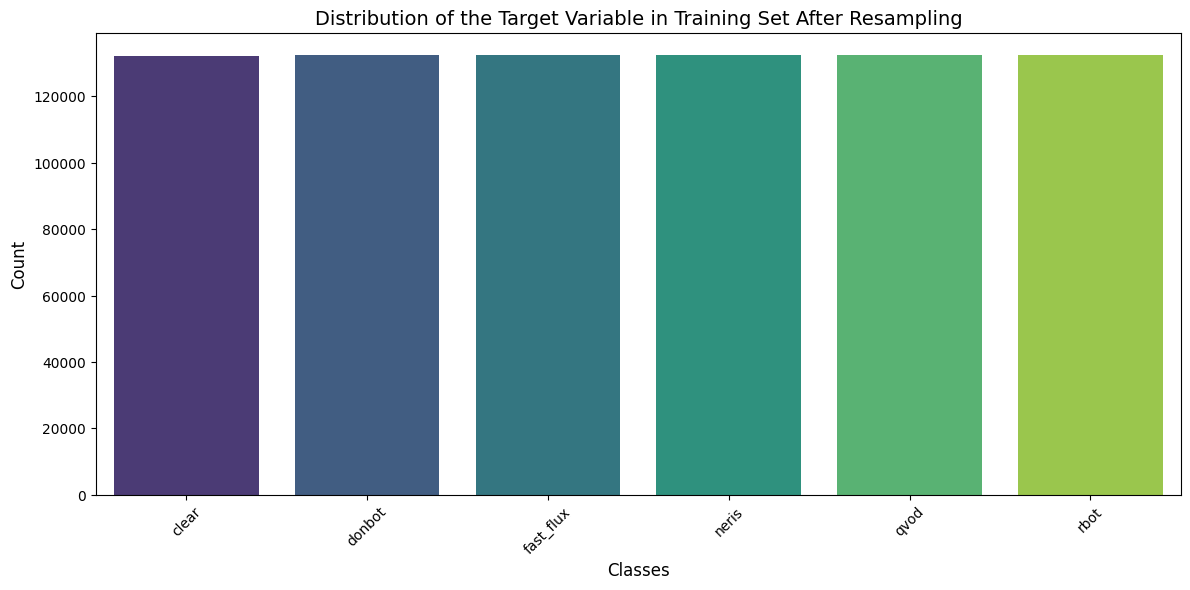

In [74]:
# 📈 Distribution of the Target Variable in Training Set After Resampling
data_array = resampled_data[0][1].flatten()

# Count the occurrences of each index
unique, counts = np.unique(data_array, return_counts=True)
index_counts = dict(zip(unique.astype(int), counts))

# Align the counts with class_labels for the barplot
mapped_counts = [index_counts.get(i, 0) for i in range(len(class_labels))]

plt.figure(figsize=(14, 6))
sns.barplot(x=class_labels, y=mapped_counts, palette='viridis')
plt.title('Distribution of the Target Variable in Training Set After Resampling', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


Evaluate models performs 5-fold cross-validation and aggregates the scores for each category using metrics:
- **precision**
- **recall**
- **f1-score**

and puts them into the table. Additionally, it produces confusion matrix as the sum of all five matrices.

# Models 🤖

---

In [31]:
STOP HERE AND RUN THE CELLS WITH YOUR MODEL

SyntaxError: invalid syntax (3198298570.py, line 1)

## Random Forest 🌳

In [30]:
# 45 min
random_forest_metrics, random_forest_conf_matrices = evaluate_models(resampled_data, [RandomForestClassifier()])


Evaluating model: RandomForestClassifier


KeyboardInterrupt: 

In [ ]:
random_forest_metrics['RandomForestClassifier']

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
precision,0.999547,0.966667,0.996793,0.983607,0.996154,0.870152,0.998856
recall,0.999330,0.793333,0.996564,0.993998,0.944223,0.709091,0.998856
f1-score,0.999438,0.852929,0.996677,0.988769,0.969104,0.776171,0.998856


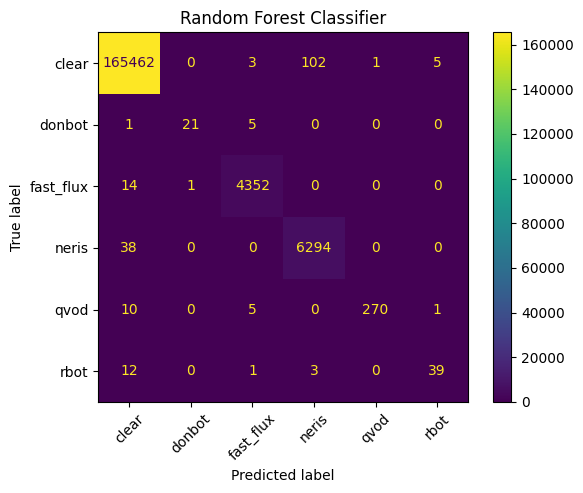

In [15]:
plot_confusion_matrix(random_forest_conf_matrices['RandomForestClassifier'], class_labels, title="Random Forest Classifier")


---

## XGBoost 🔋
XGBoost ogólnie lepszy od RandomForest

In [69]:
# 2 min
xgboost_metrics, xgboost_conf_matrices = evaluate_models(resampled_data, [XGBClassifier()])


Evaluating model: XGBClassifier


In [18]:
xgboost_metrics['XGBClassifier']

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
precision,0.999758,0.811667,0.996116,0.983657,0.985902,0.717483,0.998913
recall,0.999215,0.793333,0.997023,0.996525,0.958076,0.836364,0.998913
f1-score,0.999486,0.782533,0.996566,0.990042,0.971612,0.767484,0.998913


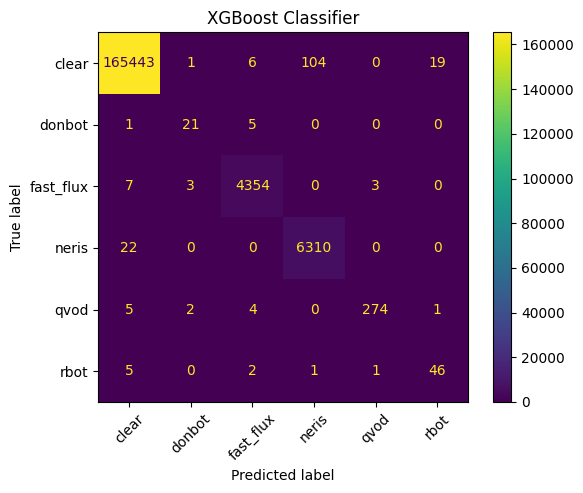

In [19]:
plot_confusion_matrix(xgboost_conf_matrices['XGBClassifier'], class_labels, title="XGBoost Classifier")

Niestety, ten model najwidoczniej przerósł możliwości mojego komputera... 😕

![image info](confusion_matrices/image/haha.png)

---

## MLP Classifier 🧠

In [ ]:
# 30 min
mlp_metrics, mlp_conf_matrices = evaluate_models(resampled_data, [MLPClassifier()])


Evaluating model: MLPClassifier


In [7]:
mlp_metrics['MLPClassifier']

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
precision,0.999692,0.836111,0.995660,0.977848,0.966195,0.639465,0.998522
recall,0.998834,0.793333,0.997252,0.994946,0.965154,0.854545,0.998522
f1-score,0.999263,0.767814,0.996452,0.986305,0.965139,0.721464,0.998522


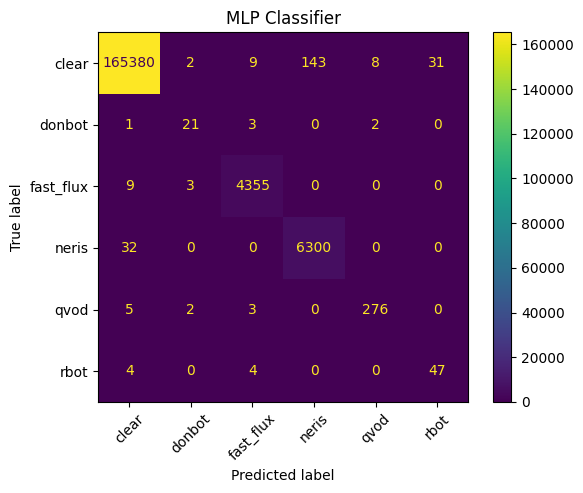

In [ ]:
plot_confusion_matrix(mlp_conf_matrices['MLPClassifier'], class_labels, title="MLP Classifier")

*Easteregg*: stronka gdzie możesz wpisać słowo i znaleźć fajną emotkę, którą potem wkleisz obok nazwy modelu: [Jestem tutaj](https://emojipedia.org/).